# Evaluation of GPU memory consumption for CUDA Tensors

In [1]:
import os
from datetime import datetime

import pandas as pd

## Data loading

At first, we specify the paths necessary for evaluation. This includes:
- the ocp metrics directory stored in `ocp_metrics_path`
- the directory `directory` for the specific model/series of runs we would like to consider
- the runs `runs` as a `dict` with shorter name as key and the respective csv filenames without "_resources/..." extensions

In [2]:
ocp_metrics_path = "/Users/danielherbst/Desktop/ocp-metrics"
directory = "s2ef/gemnet_xl/batch_size_2"
runs = {
    "stage0":                                           "1658821209_stage0_8gpus",
    "stage0_fp16":                                      "1658836096_stage0_8gpus_fp16",
    "stage1":                                           "1658796065_stage1_8gpus",
    "stage1_ocomm":                                     "1658874784_stage1_8gpus",
    "stage2_ocomm":                                     "1658848228_stage2_8gpus",
    "stage2_offloadOptimizer[cpu]_ocomm":               "1658859227_stage2_8gpus_offloadOptimizer[cpu]",
    "stage3_ocomm":                                     "1658884621_stage3_8gpus"
}

In [3]:
def get_paths(runs, csv_type) -> dict:
    """
    runs:       dict of runs with timestamp
    directory:  directory in which the runs are stored
    sv_type:    ["resources"|"torch_cuda"] 
    TODO: add support for runtimes
    """
    if csv_type == "resources":
        return {key: os.path.join(ocp_metrics_path, directory, f"{run}_resources.csv") for key, run in runs.items()}
    elif csv_type == "torch_cuda":
        return {key: os.path.join(ocp_metrics_path, directory, f"{run}_torch_cuda.csv") for key, run in runs.items()}
    else:
        raise ValueError(f"CSV type {csv_type} is not supported.")

def get_metrics_csv(file_path, csv_type) -> pd.DataFrame:
    """
    file_path:  path to the metrics csv file within the ocp metrics folder
    csv_type:   ["resources"|"torch_cuda"]
    TODO: add support for runtimes
    """
    df = pd.read_csv(os.path.join(ocp_metrics_path, file_path))
    if csv_type == "resources":
        for header in ["memory_used", "memory_free"]:
            df[header] = df[header] / 1_000_000
    elif csv_type == "torch_cuda":
        for header in ["gpu_memory_allocated", "gpu_memory_reserved"]:
            df[header] = df[header] / 1_000_000
    else:
        raise ValueError(f"CSV type {csv_type} is not supported.")
    return df

In [4]:
resources_paths = get_paths(runs, csv_type="resources")
torch_cuda_paths = get_paths(runs, csv_type="torch_cuda")

## Inspection of a single run

At first, we inspect single runs with a set DeepSpeed configuration. We look at statistical summaries of the allocated and reserved memory.

In [5]:
cuda_df = get_metrics_csv(torch_cuda_paths["stage0"], csv_type="torch_cuda")
cuda_df

,datetime,epoch,rank,gpu_memory_allocated,gpu_memory_reserved
0,2022-07-26 07:40:11.698359,0,0,2367.652864,2562.719744
1,2022-07-26 07:40:11.699225,0,1,2367.652864,2562.719744
2,2022-07-26 07:40:11.700212,0,2,2367.652864,2562.719744
3,2022-07-26 07:40:11.700135,0,7,2367.652864,2562.719744
4,2022-07-26 07:40:11.699473,0,6,2367.652864,2562.719744
...,...,...,...,...,...
199995,2022-07-26 11:47:09.023206,0,5,7142.172160,42440.065024
199996,2022-07-26 11:47:09.023281,0,2,7092.075520,31929.139200
199997,2022-07-26 11:47:09.023545,0,4,7103.862272,43186.651136
199998,2022-07-26 11:47:09.023682,0,3,7103.119360,38767.951872


In [6]:
def cuda_memory_summary_per_gpu(cuda_df) -> pd.DataFrame:
    """
    Returns statistical summary of the cuda memory usage per rank.
    """
    return cuda_df.groupby("rank")[["gpu_memory_allocated", "gpu_memory_reserved"]].describe()

def cuda_memory_summary_averaged(cuda_df) -> pd.DataFrame:
    """
    Returns statistical summary of the cuda memory usage averaged over all ranks.
    """
    return cuda_df[["gpu_memory_allocated", "gpu_memory_reserved"]].describe()

In [7]:
cuda_memory_summary_per_gpu(cuda_df)

gpu_memory_allocated                                                    \
                    count         mean        std          min          25%   
rank                                                                          
0                 25000.0  7105.915426  29.968638  2367.652864  7106.072064   
1                 25000.0  7095.922161  29.905436  2367.652864  7096.076288   
2                 25000.0  7091.805703  29.879399  2367.652864  7091.960832   
3                 25000.0  7102.993205  29.950163  2367.652864  7103.145472   
4                 25000.0  7103.675156  29.954507  2367.652864  7103.816704   
5                 25000.0  7141.955368  30.196596  2367.652864  7142.108160   
6                 25000.0  7111.461883  30.003724  2367.652864  7111.616000   
7                 25000.0  7116.190711  30.033638  2367.652864  7116.342272   

                                            gpu_memory_reserved                \
              50%          75%          max               count          mean   
rank                                                                            
0     7106.104320  7106.137088  7106.310144             25000.0  36599.870249   
1     7096.110592  7096.144896  7096.308736             25000.0  37944.071364   
2     7091.993088  7092.027392  7092.166656             25000.0  30868.330848   
3     7103.184384  7103.217664  7103.397376             25000.0  36325.355317   
4     7103.859712  7103.906304  7104.090624             25000.0  42139.615536   
5     7142.144000  7142.181888  7142.385152             25000.0  37945.334185   
6     7111.651328  7111.686784  7111.860736             25000.0  43228.769582   
7     7116.380672  7116.417024  7116.589056             25000.0  36632.327115   

                                                                          \
              std          min           25%           50%           75%   
rank                                                                       
0     3297.506880  2562.719744  33619.443712  38587.596800  38587.596800   
1     2277.630726  2562.719744  38791.020544  38791.020544  38791.020544   
2     1437.031741  2562.719744  29288.824832  31929.139200  31929.139200   
3     2892.795111  2562.719744  35777.413120  35777.413120  38767.951872   
4     1969.011986  2562.719744  39875.248128  43186.651136  43186.651136   
5     2797.255577  2562.719744  36064.722944  39246.102528  39246.102528   
6     3274.584182  2562.719744  41584.427008  44570.771456  44570.771456   
7     1443.623741  2562.719744  37163.630592  37163.630592  37163.630592   

                    
               max  
rank                
0     38587.596800  
1     38791.020544  
2     31929.139200  
3     38767.951872  
4     43186.651136  
5     42440.065024  
6     44570.771456  
7     37163.630592

In [8]:
cuda_memory_summary_averaged(cuda_df)

,gpu_memory_allocated,gpu_memory_reserved
count,200000.000000,200000.000000
mean,7108.739952,37710.459275
std,33.311518,4363.337636
min,2367.652864,2562.719744
25%,7096.283904,35777.413120
50%,7104.087040,38587.596800
75%,7111.840128,39873.150976
max,7142.385152,44570.771456


For a single run, the GPU CUDA torch memory consumption can be plotted versus time, individually on each GPU or averaged/summed across all involved GPUs.

In [9]:
def plot_cuda_memory(cuda_df, mode="individual"):
    """
    Plot the GPU memory allocated by or reserved for Cuda tensors over time.

    mode:
        "individual":   Plot memory consumption for each rank individually.
        "averaged":     Plot memory consumption averaged over the GPUs.
        "sum":          Plot total memory consumption summed up over all GPUs.
    """
    if mode == "individual":
        cuda_plot_df = cuda_df.set_index("datetime")
        cuda_plot_df.index = pd.to_datetime(cuda_plot_df.index).strftime("%H:%M")
        for rank, group in cuda_plot_df.groupby("rank"):
            group[["gpu_memory_allocated", "gpu_memory_reserved"]].plot(
                xlabel="time", 
                ylabel="memory in MB",
                title=f"Rank {rank} GPU memory"
            )
    if mode in ["averaged", "sum"]:
        cuda_df_aggr = sum([
            cuda_df[cuda_df["rank"] == rank].reset_index(drop=True)[["gpu_memory_allocated", "gpu_memory_reserved"]]
            for rank in cuda_df["rank"].unique()
        ])
        cuda_df_aggr.index = pd.to_datetime(cuda_df[cuda_df["rank"] == 0].set_index("datetime").index).strftime("%H:%M")
        if mode == "averaged":
            cuda_df_aggr = cuda_df_aggr / cuda_df["rank"].nunique()
            title = "Averaged GPU memory"
        elif mode == "sum":
            title = "Total GPU memory"
        cuda_df_aggr.plot(
            xlabel="time",
            ylabel="memory in MB",
            title=title
        )

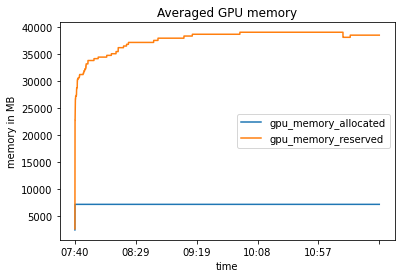

In [10]:
plot_cuda_memory(cuda_df, mode="averaged")

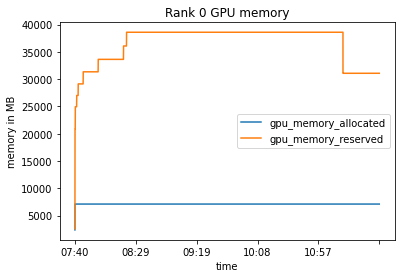

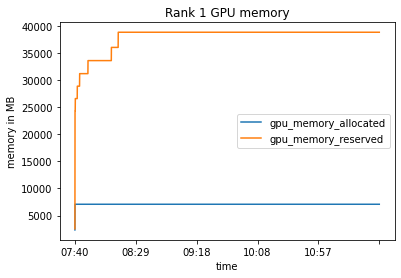

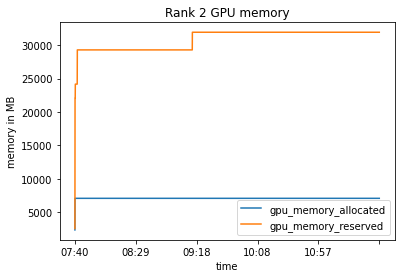

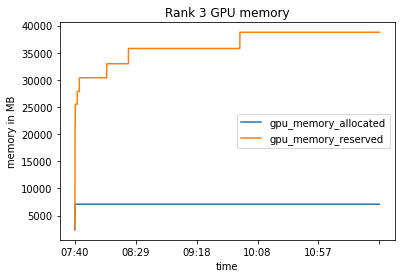

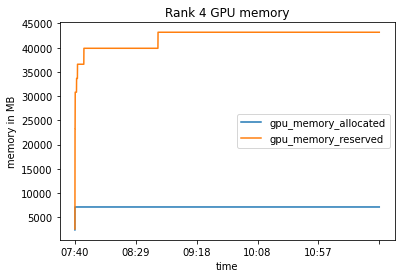

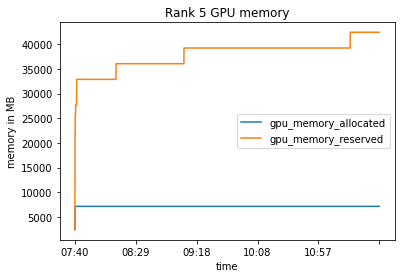

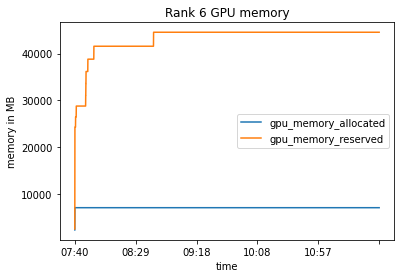

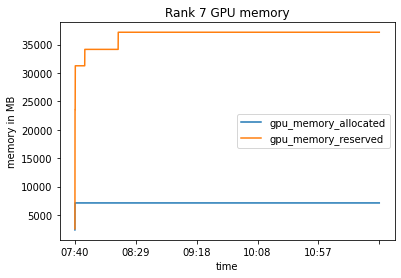

In [11]:
plot_cuda_memory(cuda_df, mode="individual")

## Comparison of different runs

For different runs, the allocated and reserved GPU CUDA memory can be compared using the function below.

In [12]:
def compare_cuda_memory_along_runs(runs) -> pd.DataFrame:
    """
    Compare cuda memory usage over all runs that are provided.
    """
    torch_cuda_paths = get_paths(runs, csv_type="torch_cuda")
    memory_runs = {}
    for key, run in runs.items():
        cuda_df = get_metrics_csv(torch_cuda_paths[key], csv_type="torch_cuda")
        memory_runs[key] = cuda_df[["gpu_memory_allocated", "gpu_memory_reserved"]].mean()
    return pd.DataFrame(memory_runs).T

In [13]:
compare_cuda_memory_along_runs(runs)

,gpu_memory_allocated,gpu_memory_reserved
stage0,7108.739952,37710.459275
stage0_fp16,7096.134937,24976.606521
stage1,2357.129914,18985.168289
stage1_ocomm,2357.129914,18985.183263
stage2_ocomm,2357.129914,20296.181880
stage2_offloadOptimizer[cpu]_ocomm,1775.432378,19770.469924
stage3_ocomm,3509.752804,21989.350514


In [14]:
def plot_cuda_memory_along_runs(runs):
    """
    Plot the allocated and reserved cuda memory usage over
    all runs that were concucted.
    """
    runs_df = compare_cuda_memory_along_runs(runs)
    runs_df.plot.bar(
        ylabel="memory in MB",
        title="Averaged GPU memory",
        figsize=(15, 7)
    )

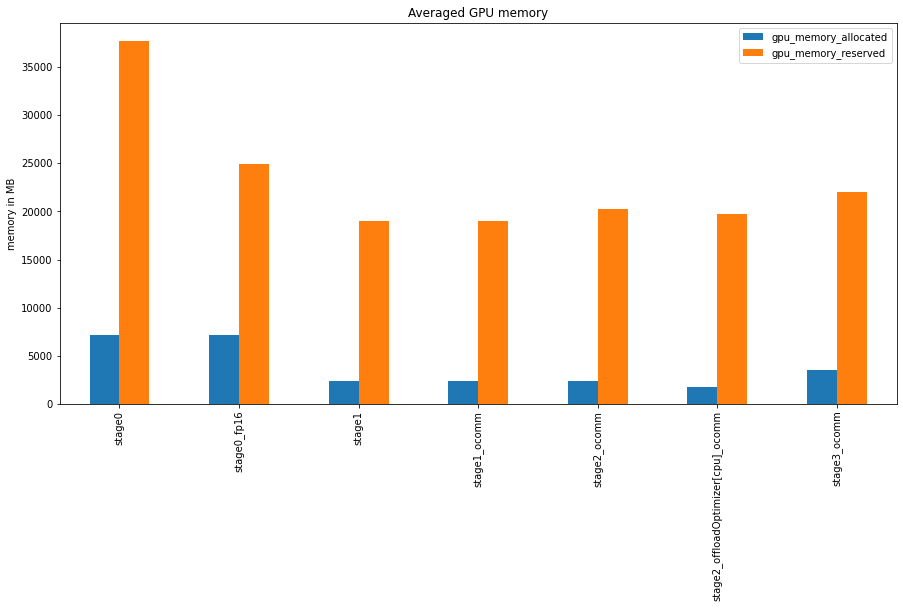

In [15]:
plot_cuda_memory_along_runs(runs)